# Stock Rotation Strategy

Transaction costs not included

In [2]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from datetime import datetime
import plotly as py
import re
import calendar
from tqdm import tqdm_notebook

pd.set_option('max.columns', None)
mpl.rcParams['figure.figsize'] = [12,8]

%matplotlib inline

In [3]:
ends_of_month = []

for year in range(2020, 2022):
    for month in range(1,13):
        last_day = calendar.monthrange(year, month)
        ends_of_month.append(f'{year}-{month}-{last_day[1]}')
        
ends_of_month = pd.DataFrame(ends_of_month).rename(columns={0:'end_of_month'})

ends_of_month['end_of_month'] = pd.to_datetime(ends_of_month['end_of_month'], format="%Y-%m-%d")

In [4]:
ends_of_month

,end_of_month
0,2020-01-31
1,2020-02-29
2,2020-03-31
3,2020-04-30
4,2020-05-31
5,2020-06-30
6,2020-07-31
7,2020-08-31
8,2020-09-30
9,2020-10-31


## 1. Import Data

In [5]:
ETFs = [f'XL{letter}' for letter in 'PYEVFIKBU'] + ['TLT'] + ['SPY']
SECTORS_ETFs = ETFs[:-2]

TICKERS = ' '.join(ETFs)
START_DATE = "2000-01-01"
END_DATE = datetime.today().strftime("%Y-%m-%d")

In [6]:
data = yf.download(tickers=TICKERS, start=START_DATE, end=END_DATE)

[*********************100%***********************]  11 of 11 completed


In [7]:
data.head()

Adj Close                                                 \
                  SPY TLT        XLB        XLE       XLF        XLI   
Date                                                                   
1999-12-31  99.116180 NaN  16.415255  16.509573  9.703183  20.085878   
2000-01-03  98.146072 NaN  16.038898  16.185848  9.339555  19.566502   
2000-01-04  94.307983 NaN  15.884490  15.881177  8.931267  19.025940   
2000-01-05  94.476685 NaN  16.540718  16.300108  8.861094  18.941141   
2000-01-06  92.958336 NaN  16.965336  16.928490  9.250244  19.195528   

                                                                      Close  \
                  XLK        XLP        XLU        XLV        XLY       SPY   
Date                                                                          
1999-12-31  41.738064  14.093208  13.253665  22.667290  23.988661  146.8750   
2000-01-03  42.948547  13.921101  12.929862  22.231598  23.264652  145.4375   
2000-01-04  40.769653  13.529092  12.539836  21.727116  22.564785  139.7500   
2000-01-05  40.164398  13.768129  12.856272  21.532202  22.287245  140.0000   
2000-01-06  38.832848  14.026282  12.834202  21.600996  22.540649  137.7500   

                                                                     \
           TLT        XLB       XLE        XLF        XLI       XLK   
Date                                                                  
1999-12-31 NaN  26.578125  27.09375  19.305950  29.609375  53.87500   
2000-01-03 NaN  25.968750  26.56250  18.582453  28.843750  55.43750   
2000-01-04 NaN  25.718750  26.06250  17.770105  28.046875  52.62500   
2000-01-05 NaN  26.781250  26.75000  17.630484  27.921875  51.84375   
2000-01-06 NaN  27.468750  27.78125  18.404753  28.296875  50.12500   

                                                             High      \
                  XLP        XLU        XLV        XLY        SPY TLT   
Date                                                                    
1999-12-31  23.031250  28.140625  30.890625  31.062500  147.50000 NaN   
2000-01-03  22.750000  27.453125  30.296875  30.125000  148.25000 NaN   
2000-01-04  22.109375  26.625000  29.609375  29.218750  144.06250 NaN   
2000-01-05  22.500000  27.296875  29.343750  28.859375  141.53125 NaN   
2000-01-06  22.921875  27.250000  29.437500  29.187500  141.50000 NaN   

                                                                            \
                  XLB       XLE        XLF        XLI       XLK        XLP   
Date                                                                         
1999-12-31  26.671875  27.25000  19.496344  29.609375  54.43750  23.187500   
2000-01-03  26.687500  27.31250  19.267872  29.484375  55.62500  23.125000   
2000-01-04  26.046875  26.31250  18.201666  28.609375  54.75000  22.656250   
2000-01-05  26.812500  26.75000  17.960499  28.125000  53.06250  22.609375   
2000-01-06  27.734375  27.84375  18.518990  28.375000  52.09375  23.000000   

                                                   Low                 \
                  XLU        XLV       XLY         SPY TLT        XLB   
Date                                                                    
1999-12-31  28.171875  30.890625  31.09375  146.250000 NaN  26.000000   
2000-01-03  28.937500  31.000000  31.00000  143.875000 NaN  25.937500   
2000-01-04  27.468750  30.203125  29.81250  139.640625 NaN  25.609375   
2000-01-05  27.421875  29.781250  29.34375  137.250000 NaN  25.750000   
2000-01-06  27.250000  29.562500  29.40625  137.750000 NaN  26.781250   

                                                                         \
                XLE        XLF       XLI      XLK        XLP        XLU   
Date                                                                      
1999-12-31  26.8125  19.217100  29.25000  53.8125  22.890625  28.000000   
2000-01-03  26.3750  18.455524  28.68750  53.5000  22.468750  27.218750   
2000-01-04  25.8750  17.605097  27.93750  52.3125  22.078125  2

## 2. Visualization

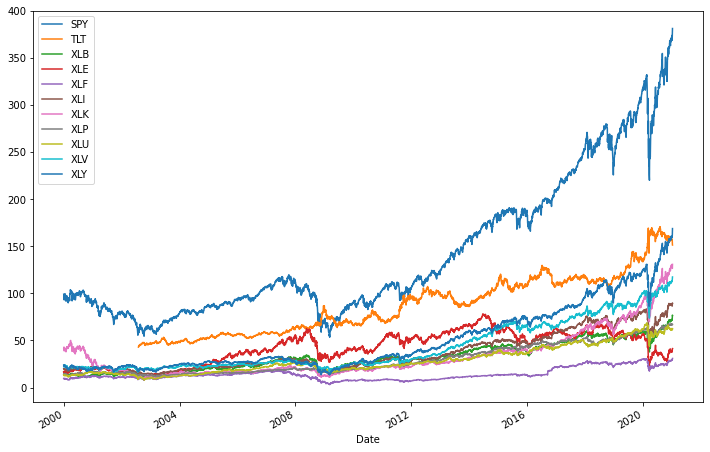

In [8]:
fig, ax = plt.subplots(figsize=(12,8))
data['Adj Close'].plot(ax=ax)
plt.show()

## 3. Returns

In [9]:
for ticker in ETFs:
    data[('returns', ticker)] = data[('Adj Close', ticker)].pct_change(1)

for ticker in  ETFs:
    data[(f'log_returns', ticker)] = np.log(data[('Adj Close', ticker)]/data[('Adj Close', ticker)].shift(1))
    
data[pd.MultiIndex.from_tuples(('returns_yesterday', sector) for sector in ETFs)] = (
    data[pd.MultiIndex.from_tuples(('returns', sector) for sector in ETFs)].shift()
)

data.dropna(inplace=True)

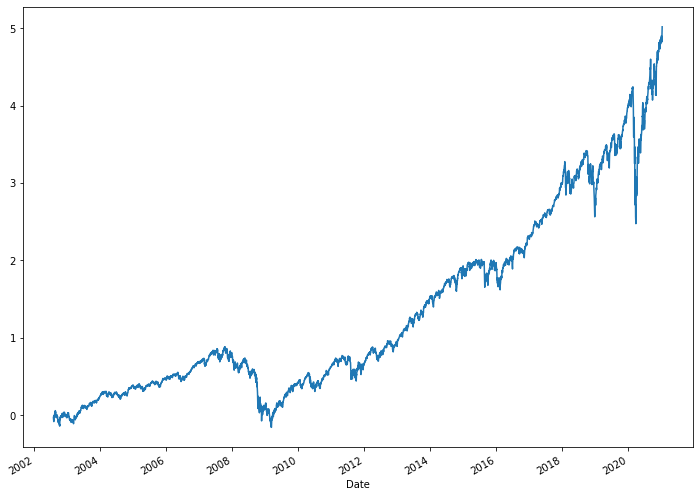

In [10]:
fig, ax = plt.subplots(figsize=(12,9))
((1 + data['returns']['SPY']).cumprod() - 1).plot(ax=ax, label='SPY')
plt.show()

## 4. Volatility

In [11]:
for ticker in SECTORS_ETFs:
    data[(f'volatility', ticker)] = data[('Adj Close', ticker)].rolling(60).std()
    
data.dropna(inplace=True)

In [12]:
data['volatility'].head()

,XLP,XLY,XLE,XLV,XLF,XLI,XLK,XLB,XLU
Date,,,,,,,,,
2002-10-24,0.395338,0.919409,0.530918,0.633035,0.585753,0.870802,0.816757,0.723280,0.979681
2002-10-25,0.395533,0.925770,0.526168,0.634507,0.587088,0.866765,0.822178,0.717886,0.983691
2002-10-28,0.398666,0.914229,0.518178,0.632313,0.588343,0.867769,0.826842,0.719046,0.986388
2002-10-29,0.398535,0.889440,0.499050,0.604650,0.585733,0.868457,0.825290,0.719853,0.990166
2002-10-30,0.398103,0.875240,0.489103,0.591365,0.586467,0.870153,0.832182,0.721069,0.989385


## 5. Inverse Volatility Ranking

In [13]:
for ticker in SECTORS_ETFs:
    data[('inverse_volatility', ticker)] = data[('volatility', ticker)].apply(lambda x: 1/x)

In [14]:
scores = data['inverse_volatility'].rank(axis=1, ascending=False)

for ticker in scores.columns:
     data[('inverse_volatility_score', ticker)] = scores[ticker]

## 6. End of Month Rebalance

In [15]:
data[('end_of_month', 'end_of_month')] = np.where(data.reset_index()['Date'].shift(-1).dt.month - data.reset_index()['Date'].dt.month> 0,
                                                  1, 0)

In [16]:
weights = pd.DataFrame(0, index=data.index, columns=SECTORS_ETFs)
weights.loc[weights.index[0], SECTORS_ETFs] = 1/9

for sector in weights.columns:
    data[('weights', sector)] = weights[sector].copy(deep=True)
    
weights = weights.join(data['end_of_month'], how='inner')    

In [17]:
for sector in SECTORS_ETFs:
    weights[sector] = np.where(weights['end_of_month'] == 1, 
                               np.where(data[('inverse_volatility_score', sector)] <= 3, 1/3, 0),
                               weights[sector])             

In [18]:
weights[weights['end_of_month'] == 1].head(10)

,XLP,XLY,XLE,XLV,XLF,XLI,XLK,XLB,XLU,end_of_month
Date,,,,,,,,,,
2002-10-31,0.333333,0.0,0.333333,0.0,0.333333,0.0,0.000000,0.000000,0.000000,1
2002-11-29,0.333333,0.0,0.333333,0.0,0.333333,0.0,0.000000,0.000000,0.000000,1
2003-01-31,0.333333,0.0,0.333333,0.0,0.333333,0.0,0.000000,0.000000,0.000000,1
2003-02-28,0.333333,0.0,0.333333,0.0,0.333333,0.0,0.000000,0.000000,0.000000,1
2003-03-31,0.000000,0.0,0.333333,0.0,0.333333,0.0,0.000000,0.000000,0.333333,1
2003-04-30,0.333333,0.0,0.333333,0.0,0.000000,0.0,0.000000,0.000000,0.333333,1
2003-05-30,0.333333,0.0,0.333333,0.0,0.333333,0.0,0.000000,0.000000,0.000000,1
2003-06-30,0.333333,0.0,0.000000,0.0,0.333333,0.0,0.000000,0.333333,0.000000,1
2003-07-31,0.333333,0.0,0.000000,0.0,0.333333,0.0,0.000000,0.333333,0.000000,1


In [19]:
returns = data[['returns']].copy(deep=True)
returns.columns = returns.columns.get_level_values(1)
returns = returns.loc[weights.index]

assert (returns.index != weights.index).sum() == 0

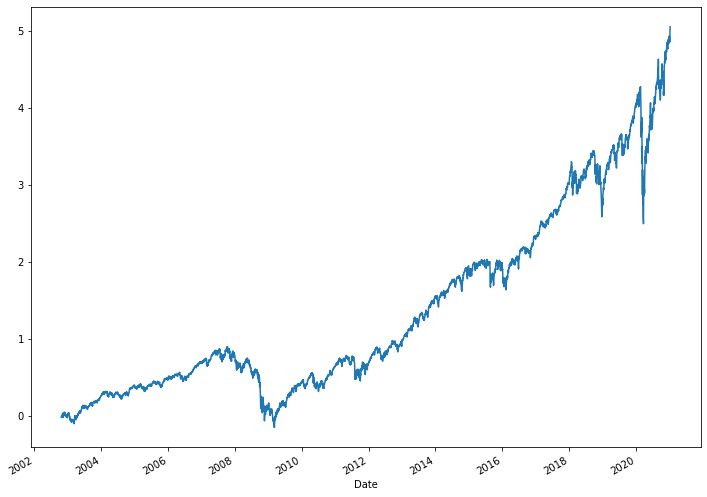

In [20]:
fig, ax = plt.subplots(figsize=(12,9))
((1 + returns['SPY']).cumprod() - 1).plot(ax=ax, label='SPY')
plt.show()

In [21]:
for today, yesterday in zip(weights.index[1:], weights.index[:-1]):
    for sector in SECTORS_ETFs:
        if weights.loc[today, 'end_of_month'] == 1:
            continue
        else:        
            weights.loc[today, sector] = (weights.loc[yesterday, sector] * (1 + returns.loc[today, sector])  /
                                         (weights.loc[yesterday, SECTORS_ETFs] * (1 + returns.loc[today, SECTORS_ETFs])).sum()
                                         )

In [22]:
weights.head(15)

,XLP,XLY,XLE,XLV,XLF,XLI,XLK,XLB,XLU,end_of_month
Date,,,,,,,,,,
2002-10-24,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0
2002-10-25,0.110171,0.111652,0.107746,0.111427,0.112186,0.110818,0.112369,0.112628,0.111003,0
2002-10-28,0.108442,0.110592,0.108250,0.111663,0.112621,0.109984,0.112869,0.111635,0.113943,0
2002-10-29,0.110922,0.111399,0.106004,0.111207,0.112331,0.109999,0.111946,0.112045,0.114147,0
2002-10-30,0.110247,0.108321,0.108385,0.110788,0.112399,0.108963,0.114589,0.110820,0.115487,0
2002-10-31,0.333333,0.000000,0.333333,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,1
2002-11-01,0.331658,0.000000,0.336180,0.000000,0.332162,0.000000,0.000000,0.000000,0.000000,0
2002-11-04,0.327562,0.000000,0.334014,0.000000,0.338424,0.000000,0.000000,0.000000,0.000000,0
2002-11-05,0.327084,0.000000,0.337114,0.000000,0.335802,0.000000,0.000000,0.000000,0.000000,0


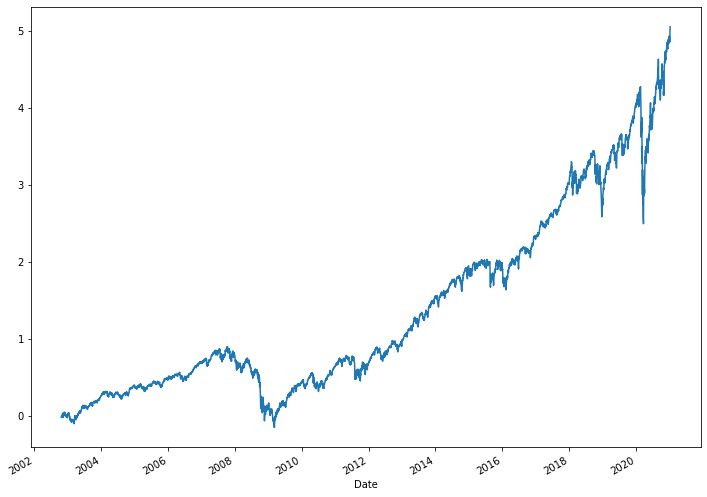

In [23]:
fig, ax = plt.subplots(figsize=(12,9))
((1 + data['returns']['SPY']).cumprod() - 1).plot(ax=ax, label='SPY')
plt.show()

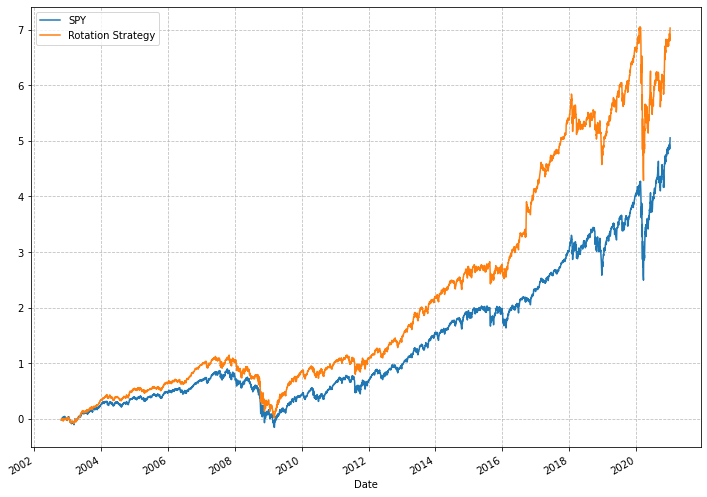

In [24]:
fig, ax = plt.subplots(figsize=(12,9))
((1 + data['returns']['SPY']).cumprod() - 1).plot(ax=ax, label='SPY')

((1 + (weights * returns).sum(axis=1)).cumprod() - 1).plot(ax=ax, label="Rotation Strategy")
plt.grid(ls='--', alpha=0.8)
plt.legend()
plt.show()

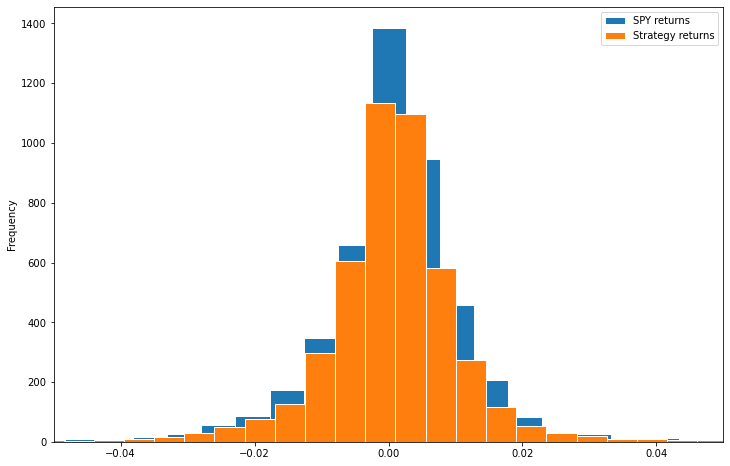

In [25]:
fig, ax = plt.subplots(figsize=(12,8))
data['returns']['SPY'].plot.hist(ax=ax, label='SPY returns', bins=50, edgecolor='white')
(returns * weights).sum(axis=1).plot.hist(ax=ax, label="Strategy returns", bins=50, edgecolor='white')
plt.legend()
plt.xlim(-0.05, 0.05)
plt.show()

In [78]:
performance = pd.DataFrame(index=['SPY', 'Stock Rotation Strategy'],
                           columns=['Sharpe Ratio', 'Mean Annual Returns', "Annual Volatility", "Cumulative Returns", "Returns Skew", "Maximum Drawdown"])

strategy_cum_rets = ((1 + (returns * weights).sum(axis=1)).cumprod() - 1)
spy_cum_rets = ((1 + data[('returns', 'SPY')]).cumprod() - 1)

drawdown = pd.DataFrame(index=weights.index, columns=['SPY', 'Stock Rotation Strategy'])
drawdown['SPY'] = spy_cum_rets/spy_cum_rets.cummax() - 1
drawdown['Stock Rotation Strategy'] = (strategy_cum_rets/strategy_cum_rets.cummax() - 1)
drawdown = drawdown.loc["2004-01-01":]

performance.loc['Stock Rotation Strategy', 'Sharpe Ratio'] = (returns * weights).sum(axis=1).mean()/(returns * weights).sum(axis=1).std() * np.sqrt(252)
performance.loc['Stock Rotation Strategy', 'Annual Volatility'] = (returns * weights).sum(axis=1).std() * np.sqrt(252)
performance.loc['Stock Rotation Strategy', 'Mean Annual Returns'] = (returns * weights).sum(axis=1).mean() * np.sqrt(252)
performance.loc['Stock Rotation Strategy', "Cumulative Returns"] = strategy_cum_rets[-1]
performance.loc['Stock Rotation Strategy', "Returns Skew"] = (returns * weights).sum(axis=1).skew()
performance.loc['Stock Rotation Strategy', "Maximum Drawdown"] = drawdown['SPY'].min()


performance.loc['SPY', 'Sharpe Ratio'] = (data[('returns', 'SPY')]).mean()/(data[('returns', 'SPY')]).std() * np.sqrt(252)
performance.loc['SPY', 'Annual Volatility'] = (data[('returns', 'SPY')]).std() * np.sqrt(252)
performance.loc['SPY', 'Mean Annual Returns'] = (data[('returns', 'SPY')]).mean() * np.sqrt(252)
performance.loc['SPY', "Cumulative Returns"] = spy_cum_rets[-1]
performance.loc['SPY', "Returns Skew"] = (data[('returns', 'SPY')]).skew()
performance.loc['SPY', "Maximum Drawdown"] = drawdown['Stock Rotation Strategy'].min()

performance = performance.T

In [79]:
performance

,SPY,Stock Rotation Strategy
Sharpe Ratio,0.613772,0.727892
Mean Annual Returns,0.00738882,0.00823138
Annual Volatility,0.191103,0.179517
Cumulative Returns,5.05416,7.0285
Returns Skew,-0.0601497,-0.10444
Maximum Drawdown,-0.985535,-1.16785


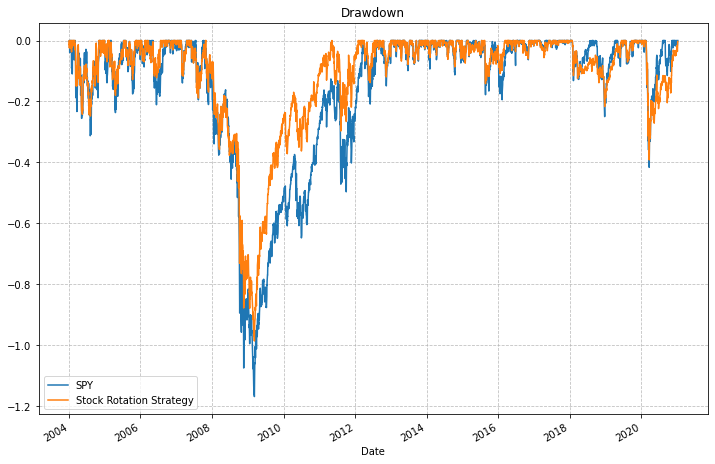

In [80]:
fig, ax = plt.subplots(figsize=(12,8))
ax.set(title="Drawdown")
drawdown.plot(ax=ax)
plt.legend(loc='best')
plt.grid(ls='--', alpha=0.8)
plt.show()